# run pilot encoding models to set parameters of pre-registrations

In [1]:
# use hbn_asd conda env

In [7]:
import pandas as pd
import nibabel as nb
import os
import numpy as np
import glob
import h5py
import hcp_utils as hcp
from sklearn.random_projection import SparseRandomProjection
#pd.set_option('display.max_rows', None)

In [ ]:
#load parcel info
atlas=pd.read_csv('/om2/user/jsmentch/atlases/atlas-Glasser/atlas-Glasser_dseg.tsv', sep='\t')
print(atlas['label'])

In [91]:
#get my parcels of interest
parcels=[
    'V1',
    'V2',
    'V3',
    'V4',
    'MT',
    'MST',
    'V4t',
    'FST',
    'FFC',
    'V8',
    'PIT',
    'VVC',
    'VMV1',
    'VMV2',
    'VMV3',
    'V3A',
    'V3B',
    'V6',
    'V6A',
    'V7',
    'IPS1',
    'IFSa',
    'IFSp',
    'IFJa',
    'IFJp',
    'FEF',
    'STSvp',
    'STSdp',
    'STSva',
    'STSda',
    'STGa',
    'STV',
    'TPOJ1',
    'TPOJ2',
    'TPOJ3',
    'A1',
    'LBelt',
    'MBelt',
    'PBelt',
    'A4',
    'TA2',
    'A5']


#auditory parcels
parcels=[
    'STSvp',
    'STSdp',
    'STSva',
    'STSda',
    'STGa',
    'STV',
    'TPOJ1',
    'TPOJ2',
    'TPOJ3',
    'A1',
    'LBelt',
    'MBelt',
    'PBelt',
    'A4',
    'TA2',
    'A5']
# 'early' auditory parcels
parcels=[
    'A1',
    'LBelt',
    'MBelt',
    'PBelt',
    'A4',
    'TA2',
    'A5']
patternR = '|'.join(['Right_' + parcel for parcel in parcels])
patternL = '|'.join(['Left_' + parcel for parcel in parcels])

# get a boolean series where True indicates a match
matches = atlas['label'].str.contains(patternR) | atlas['label'].str.contains(patternL)

# get the indices that match
indices = matches[matches].index.tolist()


In [92]:
delay=5

### load fmri data

In [93]:
pilot_subjects=pd.read_csv('../data/pilots_ru_dm.csv') # load pilot subjects
sub=pilot_subjects['Identifiers_y'].iloc[1] #get first subject

# load fmri data for a subject
im_file = '/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-NDARRP163YRC/ses-HBNsiteRU/func/sub-NDARRP163YRC_ses-HBNsiteRU_task-movieDM_space-fsLR_seg-Glasser_den-91k_stat-mean_timeseries.ptseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y=img_y[1+delay:,indices]
Y.shape
# Y_train=Y[:600,:]
# Y_test=Y[600:,:]

(744, 14)

load audio features

In [94]:
# all_layers=['input_after_preproc',
#  'conv1',
#  'bn1',
#  'conv1_relu1',
#  'maxpool1',
#  'layer1',
#  'layer2',
#  'layer3',
#  'layer4',
#  'avgpool',
#  'final/signal/word_int',
#  'final/signal/speaker_int',
#  'final/noise/labels_binary_via_int']
#my layers of interst
all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool']

#dimensionality reduction to 50 components
transformer = SparseRandomProjection(n_components=50)

stim='DM'
save_features_dir = f'../data/{stim}_clips_cochresnet50/'

X=[]
X_train=[]
X_test=[]
#print('CochResNet50 time-averaged')
# Open the file 'myfile.h5' in read-only mode
file = h5py.File(f'{save_features_dir}cochresnet50_activations.h5', 'r')
for layer in all_layers:
# # Now you can access datasets within the file
    data = file[layer]
    #print(data.shape, layer)
    X.append(  transformer.fit_transform(  np.array(data)[:(-1*delay),:]  )  )
    # X_train.append(np.array(data)[:600,:])
    # X_test.append(np.array(data)[600:,:])

# # Don't forget to close the file when you're done
file.close()

In [95]:
import numpy as np
from stacking_fmri import stacking_CV_fmri, stacking_fmri
from ridge_tools import R2
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
#timepoint n=50, first 2 layers only, 2 fold CV 
#was still not done in 1 hour

In [97]:
### Run stacking using multiple features (Xs) and Y

import time
start_time = time.time()
## with the outermost cross-validation
r2s, stacked_r2s, _, _, _, S_average = stacking_CV_fmri(Y, X, method = 'cross_val_ridge',n_folds = 5,score_f=R2)

print(time.time() - start_time)
## simple train-test setting (without the outermost cross-validation)
# r2s, stacked_r2s, _, _, _, S_average = stacking_fmri(Y[0:700], Y[700:], [X1[0:700],X2[0:700],X3[0:700]], [X1[700:],X2[700:],X3[700:]], method = 'cross_val_ridge',score_f=R2)

9.563257932662964


In [98]:
### Results

## r2s: voxelwise R2(predictions using only one feature, data)
print('shape of r2s is (number of features, dim_Y), that is', r2s.shape)

## stacked_r2s: voxelwise R2(stacking predictions using all features, data)
print('shape of stacked_r2s is (dim_Y, ), that is', stacked_r2s.shape)

## S_average: optimzed voxelwise stacking weights showing how different features are combined
print('shape of S_average is (dim_Y, num of features), that is', S_average.shape)



shape of r2s is (number of features, dim_Y), that is (8, 14)
shape of stacked_r2s is (dim_Y, ), that is (14,)
shape of S_average is (dim_Y, num of features), that is (14, 8)


In [99]:
ind = np.where(r2s > 0.01)
for i in range(len(ind[0])):
    row = ind[0][i]
    col = ind[1][i]
    #print(f"Positive value found at row {row}, column {col}")
    #print(f'layer {row+1}', atlas.iloc[col]['label'], r2s[row,col])

Text(0.5, 1.0, 'Prediction Performance')

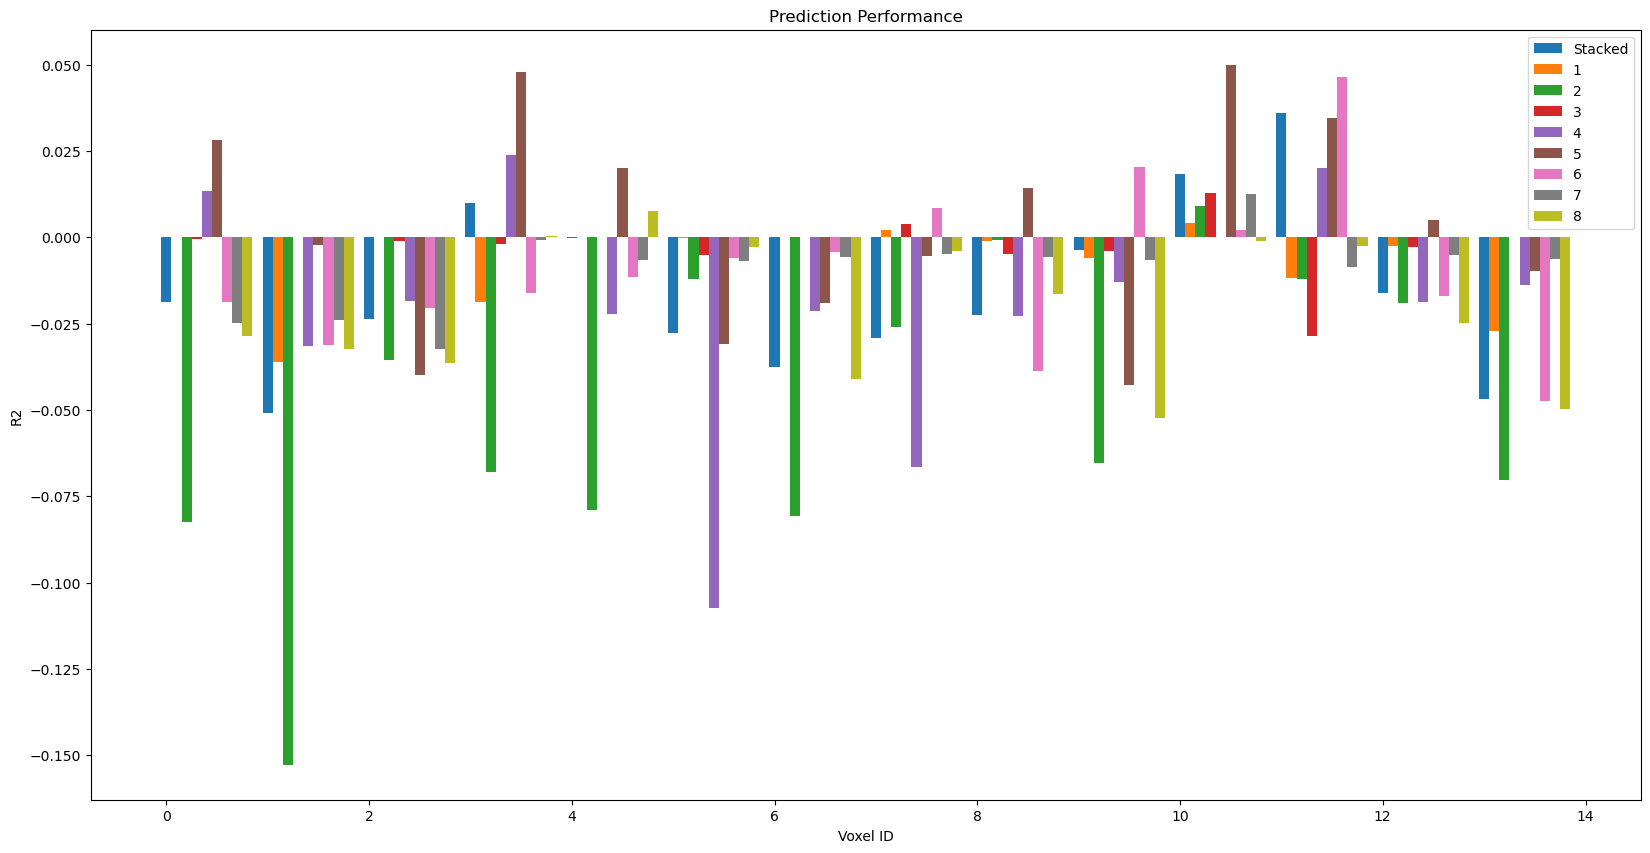

In [103]:
dim_Y=len(indices)

dim_layers=r2s.shape[0]

plt.figure(figsize=(20,10))

bar_width = 0.1
index_0 = np.arange(dim_Y)
# index_1 = index_0 + bar_width
# index_2 = index_1 + bar_width
# index_3 = index_2 + bar_width


plt.bar(index_0, stacked_r2s, width=bar_width, label='Stacked')
for i in np.arange(dim_layers):
    plt.bar(index_0+((i+1)*bar_width), r2s[i,:], width=bar_width, label=f'{i+1}')

# plt.bar(index_1, r2s[0,:], width=bar_width, label='X1')
# plt.bar(index_2, r2s[1,:], width=bar_width, label='X2')
# plt.bar(index_3, r2s[2,:], width=bar_width, label='X3')
plt.legend()
plt.xlabel('Voxel ID')
plt.ylabel('R2')
plt.title('Prediction Performance')